In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt

## random generate numbers
n = 1000
mu = 0
sig = 1
x = np.random.normal(mu,sig, (n,3))
y = np.random.normal(mu,sig, (n,1))

b = np.array([1,1,5]).reshape(-1,1)
y += x@b
## real beta is [1,1.5]

In [2]:
class data_generate_process:
    def __init__(self, x, y):
        self.x = x
        self.y = y    
        
    def split(self, rate = 0.7, random_state = 1024, scale = False):
        ## Feature scaling is used to normalize the range of independent variables or features of data
        if scale:
            self.x = (self.x - np.mean(self.x))/x.std()
        
        n = len(self.y)
        np.random.seed(random_state)
        
        ##randomly spilte data into 70% train and 30% test
        index = list(range(n))
        np.random.shuffle(index)
        train = index[:int(rate*n)]
        test = index[int(rate*n):]
        
        self.train_x = self.x[train]
        self.test_x = self.x[test]
        self.train_y = self.y[train]
        self.test_y = self.y[test]
        
        return self.train_x, self.test_x, self.train_y, self.test_y

class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def bias(self, intercept):
        ## if need intercept, add column x0 as 1
        if intercept:
            n = len(self.x)
            ones = np.ones((n,1))
            return np.hstack([ones,self.x])
        return self.x
    
    def tidy(self, x, tails = 2):
        
        n, k = x.shape
        self.error = self.y - x@self.beta 

        self.vb = self.error.var()*np.linalg.inv(x.T@x)
        self.se = np.sqrt(np.diagonal(self.vb)).reshape(-1,1)
        self.t = np.divide(self.beta,self.se)
        self.pval = tails * (1 - stats.norm.cdf(self.t))
        
        names = ['Coef','Std err','t','p-value']
        values = [self.beta, self.se, self.t, self.pval]
        values = np.hstack(values)
        
        self.summary = pd.DataFrame(values, columns =names)

        self.rsq = 1 - self.error.var()/self.y.var()
        self.adjrsq = self.rsq*(n -1)/(n-k-1)
        
        var = self.error.var()
        ## sum function here is useless, but just in order to get a list, rather than a list in a list
        ## in this case, it's easily to plot graph
        self.sse = sum(self.error.T@self.error)
        
        logl = -n/2*np.log(2*var*math.pi) - 1/2/var*self.sse
        self.logl = logl.tolist()
        
        self.aic = -2*(logl)+ 2*k 
        self.bic = -2*(logl)+ k*np.log(n) 
        
        names = ['r.squared','adj.rsq','df','loglikehood','aic','bic']
        values = [self.rsq,self.adjrsq,n-k-1,logl,self.aic,self.bic]
        glance= pd.DataFrame(columns = ['r.squared','adj.rsq','df','loglikehood','aic','bic'])
        glance.loc[0] = values
        
        self.glance = glance 
        return  self.summary
    
    def least_square(self, intercept = False):
        x = self.bias(intercept)
        
        xx = x.T@x
        xy = x.T@self.y
        
        self.beta = np.linalg.solve(xx,xy)
        return self.tidy(x)
    
    def ridge(self, intercept = False, lumda = 0.2):
        x = self.bias(intercept)
        
        I = lumda*np.identity(x.shape[1])
        xy = x.T@self.y
        xx = x.T@x
        self.beta = np.linalg.inv(xx+ I)@xy
        return self.tidy(x)
    
    
    def gradient_descent(self, learning_rate = 0.01, iterations = 10000, threshold = 1e-5, intercept = False, random =False):

        x = self.bias(intercept)
        m, n = np.shape(x)
        
        if random:
                ## random start
            beta = np.random.randn(n).reshape(-1,1)
        else:
            ## init beta = [1,1,1]
            beta = np.ones(n).reshape(-1,1)  
        
        for i in range(iterations):

            error = x@beta - self.y
            update = - (1/m)*learning_rate*x.T@error
            beta += update
            
            ## threshold measure if learning step is accuracy
            if np.abs(update).sum()< threshold:
                self.beta = beta
                return self.tidy(x)
            
        return Exception('Gradient did not converge')
    
    def predict(self, x, beta = None):
        if beta is None:
            return x@self.beta
        
        return x@beta
    
    def performance(self, test_y, y_pred):
        ### sum function makeds nothing but return a value that makes it easier to plot 
        return sum((test_y - y_pred).T@(test_y - y_pred))
        
            
train_x, test_x, train_y, test_y = data_generate_process(x, y).split()

In [3]:
ols = model(train_x, train_y)
ols.least_square()

,Coef,Std err,t,p-value
0,0.984821,0.038736,25.423944,0.0
1,1.030293,0.039770,25.906236,0.0
2,5.009641,0.037344,134.149149,0.0


In [4]:
ols.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.965189,0.969349,696,[-1005.9707810169177],[2017.9415620338355],[2031.5948030389657]


In [5]:
import statsmodels.api as sm

results = sm.OLS(train_y, train_x).fit()
# Inspect the results and compared to the result in the package I built
print(results.summary())
## it's the same between OLS and this package

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              6436.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):                        0.00
Time:                        19:22:14   Log-Likelihood:                         -1006.0
No. Observations:                 700   AIC:                                      2018.
Df Residuals:                     697   BIC:                                      2032.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
ridge = model(train_x, train_y)
ridge.ridge()

,Coef,Std err,t,p-value
0,0.984585,0.038736,25.417840,0.0
1,1.029938,0.039770,25.897279,0.0
2,5.008295,0.037344,134.112951,0.0


In [7]:
ridge.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.965189,0.969349,696,[-1005.9714886671766],[2017.9429773343531],[2031.5962183394834]


In [8]:
gradient_descent = model(train_x, train_y)
gradient_descent.gradient_descent()

,Coef,Std err,t,p-value
0,0.985055,0.038736,25.429996,0.0
1,1.030074,0.039770,25.900734,0.0
2,5.009076,0.037344,134.134036,0.0


In [9]:
gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.965189,0.969349,696,[-1005.9709237108744],[2017.941847421749],[2031.595088426879]


In [10]:
random_gradient_descent = model(train_x, train_y)
random_gradient_descent.gradient_descent(random = True)

,Coef,Std err,t,p-value
0,0.984910,0.038736,25.426227,0.0
1,1.030297,0.039770,25.906321,0.0
2,5.008791,0.037344,134.126323,0.0


In [11]:
random_gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.965189,0.969349,696,[-1005.9710406697978],[2017.9420813395957],[2031.595322344726]


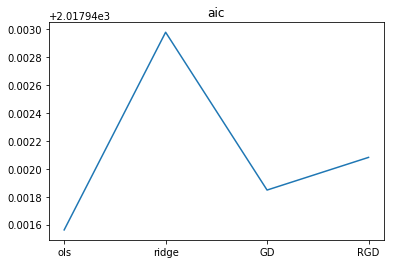

In [12]:
## Model Evulation
### 1.compared by AIC
algorithms = [ols, ridge, gradient_descent, random_gradient_descent]
names  = ['ols', 'ridge', 'GD', 'RGD']
criterion = [item.aic for item in algorithms]
plt.title('aic')
plt.plot(names , criterion)


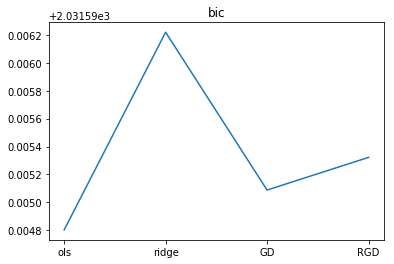

In [13]:
### 2.compared by bic
criterion = [item.bic for item in algorithms]
plt.title('bic')
plt.plot(names , criterion)

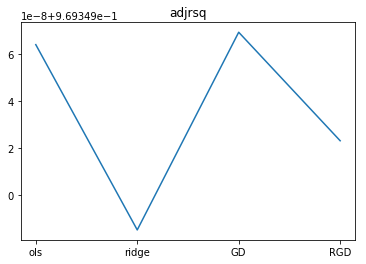

In [14]:
### 3.compared by adjrsq
criterion = [item.adjrsq for item in algorithms]
plt.title('adjrsq')
plt.plot(names , criterion)

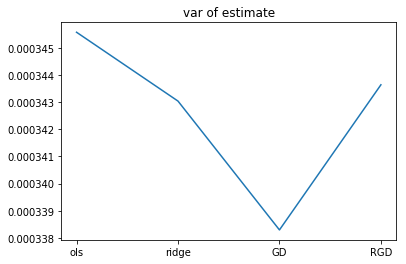

In [15]:
### 4.compared by beta.var
criterion = [(item.beta - b).var() for item in algorithms]
plt.title('var of estimate')
plt.plot(names , criterion)

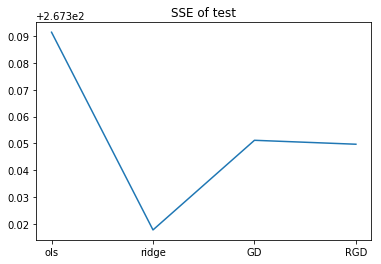

In [16]:
## 5.compared by SSE of Testing
betas = [item.beta for item in algorithms]
sse = []
for beta in betas:
    linear = model(train_x, train_y)
    y_pred = linear.predict(test_x, beta)
    sse.append(ridge.performance(test_y, y_pred))
plt.title('SSE of test')
plt.plot(names, sse)